In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm
from scipy import sparse
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# Reading Data
rating = pd.read_csv('BX-Book-Ratings.csv',sep=';', error_bad_lines=False, encoding="latin-1")
book = pd.read_csv('BX-Books.csv',sep=';', error_bad_lines=False, encoding="latin-1")
user = pd.read_csv('BX-Users.csv',sep=';', error_bad_lines=False, encoding="latin-1")

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'


In [3]:
# Changing column names of the datasets
book.columns=['isbn','title','author','yearofpublish','publisher','smallimage','mediumimage','largeimage']
user.columns=['userid','location','age']
rating.columns = ['userid','isbn','rating']

In [9]:
user.shape

(278858, 3)

In [10]:
book.shape

(271360, 8)

In [18]:
rating.shape

(1149780, 3)

# EDA

In [82]:
# There are some NAN's in Age for the user dataset
np.sort(user['age'].unique())

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 113., 114., 115., 116., 118., 119., 123., 124., 127.,
       128., 132., 133., 136., 137., 138., 140., 141., 143., 146., 147.,
       148., 151., 152., 156., 157., 159., 162., 168., 172., 175., 183.,
       186., 189., 199., 200., 201., 204., 207., 20

In [13]:
per = (user['age'][user.age>=100].value_counts().shape[0]/user.shape[0])*100
print(f"Percentage of users with Age above 90: {per} %")
per = (user['age'][user.age<5].value_counts().shape[0]/user.shape[0])*100
print(f"Percentage of users with Age less than 5: {per} %")
per = ((user['age'].isna().sum())/user.shape[0])*100
print(f'Percentage of NaN Age: {per} %')

Percentage of users with Age above 90: 0.0233093545819019 %
Percentage of users with Age less than 5: 0.0017930272755309151 %
Percentage of NaN Age: 39.71985741847105 %


In [4]:
# Assuming that the users above the age of 90 and less than 5 will not read or review a book.
# Replacing the value of those to NaN
user.loc[((user.age<=5) | (user.age>=90)), 'age']= np.nan

In [86]:
user.head()

,userid,location,age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [5]:
user[['city','state','country']] = user['location'].str.split(', ', 2,expand=True)
user.pop('location')
user.head()

,userid,age,city,state,country
0,1,NaN,nyc,new york,usa
1,2,18.0,stockton,california,usa
2,3,NaN,moscow,yukon territory,russia
3,4,17.0,porto,v.n.gaia,portugal
4,5,NaN,farnborough,hants,united kingdom


Text(0.5, 1.0, 'Age count')

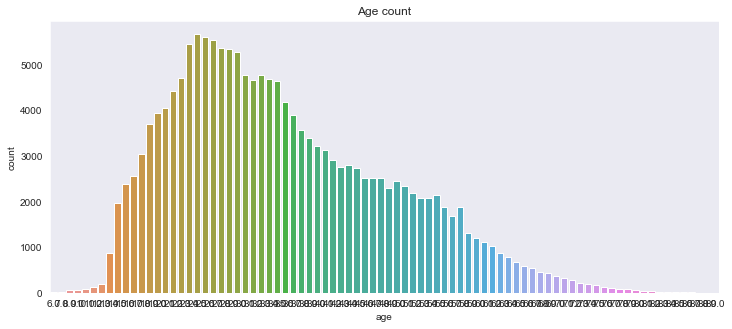

In [53]:
sns.set_style('dark')
plt.figure(figsize=(12,5))
sns.countplot(user['age'])
plt.title("Age count")

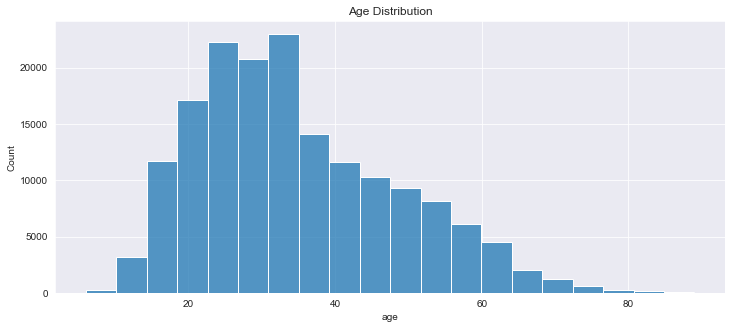

In [11]:
sns.set_style('dark')
plt.figure(figsize=(12,5))
sns.histplot(user['age'],bins=20)
plt.title("Age Distribution")
plt.grid()
plt.show()

In [66]:
user.isna().sum()

userid          0
age        112105
city            0
state           1
country         2
dtype: int64

In [95]:
# 40% of the age is missing
user['age'].isna().sum()/user.shape[0]*100

40.20146454467866

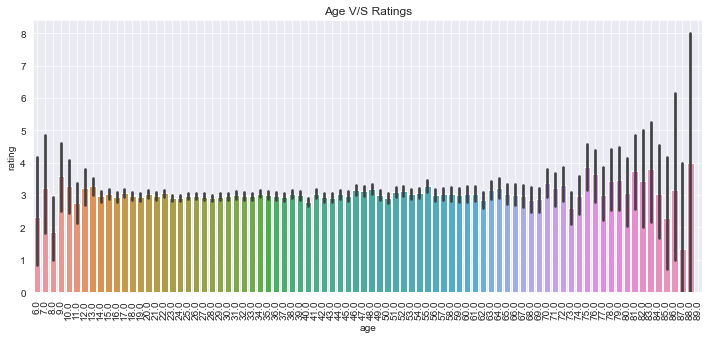

In [20]:
sns.set_style('dark')
plt.figure(figsize=(12,5))
sns.barplot(user['age'],rating['rating'])
plt.xticks(rotation=90)
plt.title("Age V/S Ratings")
plt.grid()
plt.show()

In [6]:
# As there are so many missing values for this feature, we can remove the feature from data
user.pop('age')
user.head()

,userid,city,state,country
0,1,nyc,new york,usa
1,2,stockton,california,usa
2,3,moscow,yukon territory,russia
3,4,porto,v.n.gaia,portugal
4,5,farnborough,hants,united kingdom


In [90]:
# There are no missing values in Ratings Dataset
rating.isna().sum()

userid    0
isbn      0
rating    0
dtype: int64

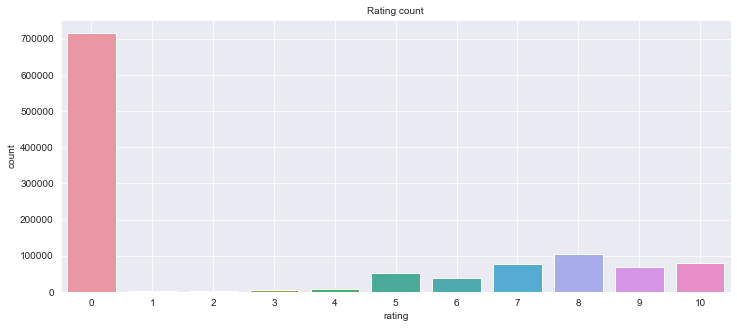

0     716109
8     103736
10     78610
7      76457
9      67541
5      50974
6      36924
4       8904
3       5996
2       2759
1       1770
Name: rating, dtype: int64

In [13]:
sns.set_style('dark')
plt.figure(figsize=(12,5))
sns.countplot(rating['rating'])
plt.title("Rating count",size=10)
plt.grid()
plt.show()
rating['rating'].value_counts()

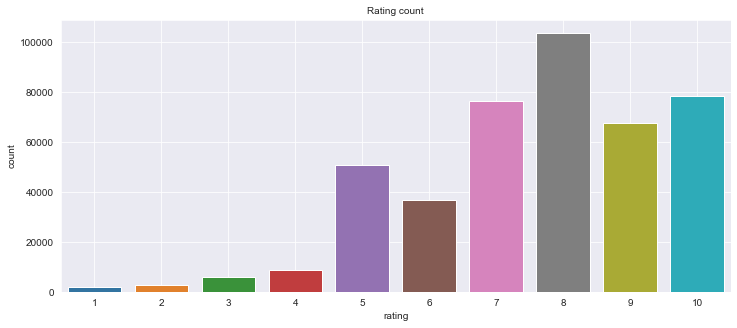

In [14]:
# We see a lot of negative reviews which dominates our data
sns.set_style('dark')
plt.figure(figsize=(12,5))
sns.countplot(rating[rating.rating>0]['rating'])
plt.title("Rating count",size=10)
plt.grid()
plt.show()

In [107]:
book.head()

,isbn,title,author,yearofpublish,publisher,smallimage,mediumimage,largeimage
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [6]:
# The URL's only contains the cover of the book, hence we would drop the book cover in our recommendations
book.drop(['smallimage','mediumimage','largeimage'],axis = 1,inplace=True)
book.head()

,isbn,title,author,yearofpublish,publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


In [39]:
book.isna().sum()

isbn             0
title            0
author           1
yearofpublish    0
publisher        2
dtype: int64

In [8]:
# LEts check out the rows with NaN values
is_NaN = book.isnull()
row_has_NaN = is_NaN.any(axis=1)
book[row_has_NaN]

,isbn,title,author,yearofpublish,publisher
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN
187689,9627982032,The Credit Suisse Guide to Managing Your Perso...,NaN,1995,Edinburgh Financial Publishing


In [7]:
# Lets check for other rows with the specific writer Simon & Schuster
mask1 = (book.title=='Tyrant Moon')
mask2 = (book.title=='Finders Keepers')
mask3 = (book.title=='The Credit Suisse Guide to Managing Your Personal Wealth')
book.loc[mask1,'publisher'] = book.loc[mask1,'publisher'].fillna('NovelBooks')
book.loc[mask2,'publisher'] = book.loc[mask2,'publisher'].fillna('Simon & Schuster')
book.loc[mask3,'author'] = book.loc[mask3,'author'].replace(np.nan,'Edinburgh Financial Publishing')

In [42]:
book.isna().sum()

isbn             0
title            0
author           0
yearofpublish    0
publisher        0
dtype: int64

In [8]:
# joining the user and rating dataset
data = pd.merge(rating,user, how='outer', on='userid')
data.reset_index(drop=True,inplace=True)
data.head()

,userid,isbn,rating,age,city,state,country
0,276725,034545104X,0.0,NaN,tyler,texas,usa
1,276726,0155061224,5.0,NaN,seattle,washington,usa
2,276727,0446520802,0.0,16.0,h,new south wales,australia
3,276729,052165615X,3.0,16.0,rijeka,n/a,croatia
4,276729,0521795028,6.0,16.0,rijeka,n/a,croatia


In [100]:
print('The Percentage of users where the rating and recommendation is missing:\n',(data.isna().sum()/data.shape[0])*100)

The Percentage of users where the rating and recommendation is missing:
 userid      0.000000
isbn       13.116284
rating     13.116284
city        0.000000
state       0.000076
country     2.180896
dtype: float64


In [101]:
print('The Percentage of users where the rating and recommendation is missing:\n',(book.isna().sum()/book.shape[0])*100)

The Percentage of users where the rating and recommendation is missing:
 isbn             0.0
title            0.0
author           0.0
yearofpublish    0.0
publisher        0.0
dtype: float64


In [46]:
data.head()

,userid,isbn,rating,age,city,state,country
0,276725,034545104X,0,NaN,tyler,texas,usa
1,276726,0155061224,5,NaN,seattle,washington,usa
2,276727,0446520802,0,16.0,h,new south wales,australia
3,276729,052165615X,3,16.0,rijeka,n/a,croatia
4,276729,0521795028,6,16.0,rijeka,n/a,croatia


In [186]:
book.head()

,isbn,title,author,yearofpublish,publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


In [49]:
data.shape

(1149780, 7)

In [50]:
book.shape

(271360, 5)

In [9]:
df = pd.merge(book,data, how='outer', on='isbn')
df.reset_index(drop=True,inplace=True)
df.shape

(1324564, 11)

In [103]:
df.isna().sum()

isbn             173575
title            292219
author           292219
yearofpublish    292219
publisher        292219
userid             1209
rating           174784
city               1209
state              1210
country           30070
dtype: int64

In [104]:
df.head()

,isbn,title,author,yearofpublish,publisher,userid,rating,city,state,country
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,2.0,0.0,stockton,california,usa
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,8.0,5.0,timmins,ontario,canada
2,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,11400.0,0.0,ottawa,ontario,canada
3,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,11676.0,8.0,n/a,n/a,n/a
4,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,41385.0,0.0,sudbury,ontario,canada


In [12]:
# LEts check out the rows with NaN values
is_NaN = df.isnull()
row_has_NaN = is_NaN.any(axis=1)
df[row_has_NaN]

,isbn,title,author,yearofpublish,publisher,userid,rating,city,state,country
8,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,116866.0,9.0,ottawa,",",None
40,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,115097.0,7.0,seattle,",",None
58,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,245827.0,9.0,albuquerque,",",None
97,1881320189,Goodbye to the Buttermilk Sky,Julia Oliver,1994,River City Pub,226745.0,7.0,humble,",",None
106,0440234743,The Testament,John Grisham,1999,Dell,5760.0,0.0,springfield,",",None
...,...,...,...,...,...,...,...,...,...,...
1324559,NaN,NaN,NaN,NaN,NaN,278853.0,NaN,stranraer,n/a,united kingdom
1324560,NaN,NaN,NaN,NaN,NaN,278855.0,NaN,tacoma,washington,united kingdom
1324561,NaN,NaN,NaN,NaN,NaN,278856.0,NaN,brampton,ontario,canada
1324562,NaN,NaN,NaN,NaN,NaN,278857.0,NaN,knoxville,tennessee,usa


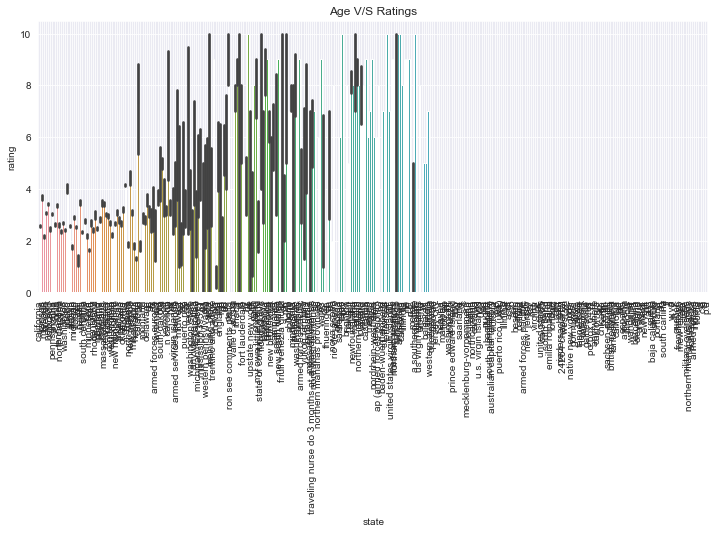

In [110]:
sns.set_style('dark')
plt.figure(figsize=(12,5))
sns.barplot(df.loc[df.country=="usa"]['state'],df['rating'])
plt.xticks(rotation=90)
plt.title("Age V/S Ratings")
plt.grid()
plt.show()

In [10]:
# There are many incorrect information in country, city and state.
# Hence lets drop the features in the field and check for the status.
df.drop(['city','country','state'],inplace=True,axis = 1)
df.head()

,isbn,title,author,yearofpublish,publisher,userid,rating,age
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,2.0,0.0,18.0
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,8.0,5.0,NaN
2,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,11400.0,0.0,49.0
3,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,11676.0,8.0,NaN
4,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,41385.0,0.0,NaN


In [11]:
df.isna().sum()

isbn             173575
title            292219
author           292219
yearofpublish    292219
publisher        292219
userid             1209
rating           174784
age              386184
dtype: int64

In [14]:
# We would keep all the nan values in a seperate dataframe for us to later fill those.
#final_nan_details = df[row_has_NaN]
#df.dropna(inplace=True)
#df.head()

,isbn,title,author,yearofpublish,publisher,userid,rating
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,2.0,0.0
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,8.0,5.0
2,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,11400.0,0.0
3,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,11676.0,8.0
4,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,41385.0,0.0


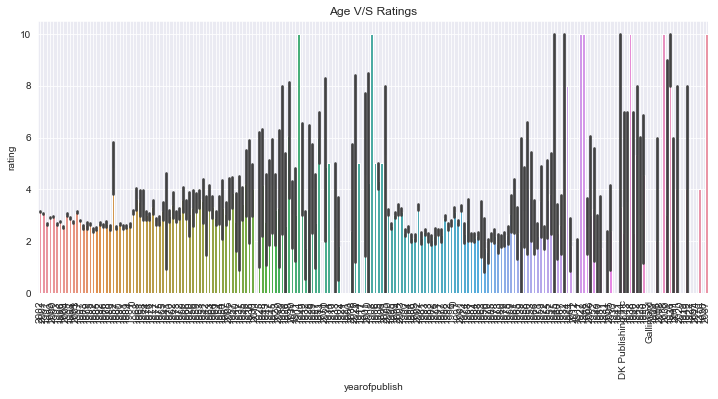

In [116]:
sns.set_style('dark')
plt.figure(figsize=(12,5))
sns.barplot(df['yearofpublish'],df['rating'])
#plt.xticks(rotation=90)
plt.title("Year V/S Rating")
plt.grid()
plt.show()

In [12]:
df['yearofpublish'].unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, '2000', '1995', '1999', '2004',
       '2003', '1990', '1994', '1986', '1989', '2002', '1981', '1993',
       '1983', '1982', '1976', '1991', '1977', '1998', '1992', '1996',
       '0', '1997', '2001', '1974', '1968', '1987', '1984', '1988',
       '1963', '1956', '1970', '1985', '1978', '1973', '1980'

In [13]:
df.reset_index(drop=True,inplace=True)
year = list(df[df.yearofpublish=='DK Publishing Inc']['yearofpublish'])[0]
aut = list(df.loc[df.yearofpublish=='DK Publishing Inc']['author'])[0]
pub = list(df.loc[df.yearofpublish=='DK Publishing Inc']['publisher'])[0]
mask = (df.yearofpublish=='DK Publishing Inc')

In [14]:
df.loc[mask,'yearofpublish'] = df.loc[mask,'yearofpublish'].replace(to_replace = year,value=aut)
df.loc[mask,'author'] = df.loc[mask,'author'].replace(to_replace=aut,value=year)
df.loc[mask,'publisher'] = df.loc[mask,'publisher'].replace(to_replace=pub,value=year)

In [15]:
pub = list(df.loc[df.author=='DK Publishing Inc']['publisher'])[2]
df.loc[mask,'publisher'] = df.loc[mask,'publisher'].replace(to_replace=pub,value=year)

In [16]:
mask = (df.yearofpublish=='Gallimard')
pub = list(df.loc[df.yearofpublish=='Gallimard']['publisher'])[0]
year = list(df.loc[df.yearofpublish=='Gallimard']['yearofpublish'])[0]
aut = list(df.loc[df.yearofpublish=='Gallimard']['author'])[0]

In [17]:
df.loc[mask,'author'] = df.loc[mask,'author'].replace(to_replace=aut,value='Jean-Marie Gustave Le Clézio')
df.loc[mask,'yearofpublish'] = df.loc[mask,'yearofpublish'].replace(to_replace=year,value=aut)
df.loc[mask,'publisher'] = df.loc[mask,'publisher'].replace(to_replace=pub,value=year)

In [20]:
df['yearofpublish'].unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, '2000', '1995', '1999', '2004',
       '2003', '1990', '1994', '1986', '1989', '2002', '1981', '1993',
       '1983', '1982', '1976', '1991', '1977', '1998', '1992', '1996',
       '0', '1997', '2001', '1974', '1968', '1987', '1984', '1988',
       '1963', '1956', '1970', '1985', '1978', '1973', '1980'

In [19]:
df[df.yearofpublish==2050]

,isbn,title,author,yearofpublish,publisher,userid,rating,age
698554,0140301690,Alice's Adventures in Wonderland and Through t...,Lewis Carroll,2050,Puffin Books,40029.0,10.0,26.0
698555,0140301690,Alice's Adventures in Wonderland and Through t...,Lewis Carroll,2050,Puffin Books,41700.0,7.0,42.0
698556,0140301690,Alice's Adventures in Wonderland and Through t...,Lewis Carroll,2050,Puffin Books,76626.0,0.0,38.0
698557,0140301690,Alice's Adventures in Wonderland and Through t...,Lewis Carroll,2050,Puffin Books,82831.0,7.0,21.0
698558,0140301690,Alice's Adventures in Wonderland and Through t...,Lewis Carroll,2050,Puffin Books,240144.0,0.0,34.0
751306,0140201092,Outline of European Architecture (Pelican S.),Nikolaus Pevsner,2050,Penguin USA,165503.0,10.0,17.0
751307,0140201092,Outline of European Architecture (Pelican S.),Nikolaus Pevsner,2050,Penguin USA,260944.0,0.0,NaN


In [21]:
# The data in 'yearofpublish' is not accurate for most of the prts, hence we are going to drop the data
df.drop(['yearofpublish'],axis = 1, inplace=True)
df.head()

,isbn,title,author,publisher,userid,rating,age
0,0195153448,Classical Mythology,Mark P. O. Morford,Oxford University Press,2.0,0.0,18.0
1,0002005018,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,8.0,5.0,NaN
2,0002005018,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,11400.0,0.0,49.0
3,0002005018,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,11676.0,8.0,NaN
4,0002005018,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,41385.0,0.0,NaN


In [87]:
# We are going to build a simple recommecdation system where the users would be recommended a book as per
# their historical data.

,isbn,title,author,publisher,userid,rating
62608,0553296981,Anne Frank: The Diary of a Young Girl,ANNE FRANK,Bantam,45822.0,10.0
72455,0451187903,Sense and Sensibility,Jane Austen,Signet Book,45822.0,0.0
729052,031263546X,The practice of writing,Robert E Scholes,St. Martin's Press,45822.0,4.0
729059,0553563300,The Doctor's Sweetheart and Other Stories,L. M. Montgomery,Bantam Books,45822.0,0.0


In [22]:
# ISBN:- "International Standard Book Number".
# This number should be unique for each book. But we see that for a single book there are nultiple isbn
# It could be due to different means of publishing and also different copies on different times.
df[df.title=="Sense and Sensibility"]['isbn'].unique()

array(['0451187903', '0451525892', '0812543122', '0140434259',
       '0460010212', '1561387053', '1853268496', '0553211102',
       '0451521854', '0140239316', 'B00005BBW4', '0681218908'],
      dtype=object)

In [23]:
print("Total percentage of unique books: ",(len(df['isbn'].unique())/df.shape[0])*100)

Total percentage of unique books:  25.802150745452845


In [103]:
len(book['isbn'].unique())

271360

In [104]:
len(book['title'].unique())

242135

In [108]:
len(df['userid'].unique())

92106

In [127]:
(df.loc[(df.rating>0)]['isbn'].unique()).shape

(149836,)

In [130]:
df.title.unique()

array(['Classical Mythology', 'Clara Callan', 'Decision in Normandy', ...,
       'Lily Dale : The True Story of the Town that Talks to the Dead',
       "Republic (World's Classics)",
       "A Guided Tour of Rene Descartes' Meditations on First Philosophy with Complete Translations of the Meditations by Ronald Rubin"],
      dtype=object)

In [24]:
# Ratings should be between 1-10, hence removing all 0 ratings
df = df[df.rating>0]
df.head()

,isbn,title,author,publisher,userid,rating,age
1,0002005018,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,8.0,5.0,NaN
3,0002005018,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,11676.0,8.0,NaN
5,0002005018,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,67544.0,8.0,30.0
8,0002005018,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,116866.0,9.0,NaN
9,0002005018,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,123629.0,9.0,NaN


In [26]:
df.shape

(433671, 7)

In [27]:
# We know that against one ISBN number there can be only one title.
# Hence we need to create our dataset with that
print(len(df.title.unique()))
print(len(df.isbn.unique()))

135568
185973


In [35]:
# Now for each book title, we are going to assign one single isbn value
from tqdm import tqdm
for i in tqdm(list(df['title'].unique())):
    mark = (df.title==i)
    first_uniq_isbn = list(df[mark]['isbn'].unique())[0]
    isbn_uniq = list(df.loc[mark]['isbn'].unique())
    count = len(isbn_uniq)
    if count > 1:
        for j in isbn_uniq:
            df.loc[mark,'isbn']=df.loc[mark,'isbn'].replace(j,first_uniq_isbn)

100%|███████████████████████████████████████████████████████████████████████▉| 135567/135568 [1:14:58<00:00, 30.14it/s]


IndexError: list index out of range

In [36]:
df.to_csv('data.csv', index=False) 

In [ ]:
df['isbn'].unique().sum()

In [165]:
df[mark]['isbn'].unique().shape[0]

1

In [167]:
first_uniq_isbn*df[mark]['isbn'].unique().shape[0]

'0002005018'

In [176]:
a = []
for i in range(10):
    a.append(list(df[mark]['isbn'].unique())[0])
print(a)

['0002005018', '0002005018', '0002005018', '0002005018', '0002005018', '0002005018', '0002005018', '0002005018', '0002005018', '0002005018']


In [2]:
books = pd.read_csv('BX-Books.csv', sep=';', error_bad_lines=False, encoding="latin-1")
books.columns = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']
users = pd.read_csv('BX-Users.csv', sep=';', error_bad_lines=False, encoding="latin-1")
users.columns = ['userID', 'Location', 'Age']
ratings = pd.read_csv('BX-Book-Ratings.csv', sep=';', error_bad_lines=False, encoding="latin-1")
ratings.columns = ['userID', 'ISBN', 'bookRating']

print(ratings.shape)
print(list(ratings.columns))

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'


(1149780, 3)
['userID', 'ISBN', 'bookRating']


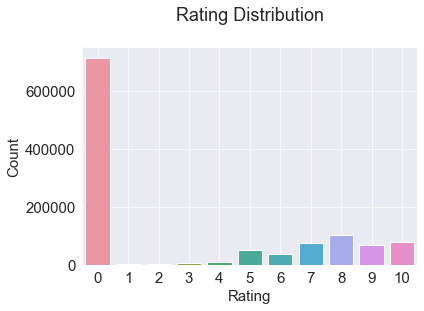

In [10]:
plt.rc("font", size=15)
sns.set_style('dark')
sns.countplot(ratings['bookRating'])
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.grid()
plt.show()

In [4]:
print(books.shape)
print(list(books.columns))

(271360, 8)
['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']


In [5]:
print(users.shape)
print(list(users.columns))

(278858, 3)
['userID', 'Location', 'Age']


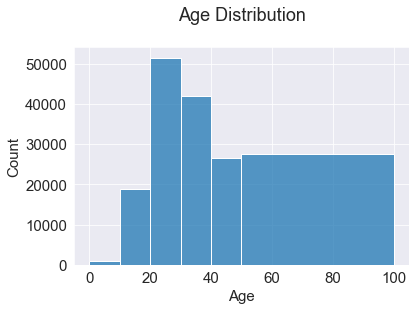

In [9]:
sns.set_style('dark')
sns.histplot(users['Age'],bins=[0, 10, 20, 30, 40, 50, 100])
plt.title('Age Distribution\n')
plt.xlabel('Age')
plt.ylabel('Count')
plt.grid()
plt.show()

In [11]:
counts1 = ratings['userID'].value_counts()
ratings = ratings[ratings['userID'].isin(counts1[counts1 >= 20].index)]
counts = ratings['bookRating'].value_counts()
ratings = ratings[ratings['bookRating'].isin(counts[counts >= 10].index)]

In [50]:
ratings['userID'].isin(counts1[counts1 == 21].index)

31         False
32         False
33         False
34         False
35         False
           ...  
1149744    False
1149745    False
1149746    False
1149747    False
1149748    False
Name: userID, Length: 888884, dtype: bool

In [30]:
ratings.shape

(888884, 3)

In [31]:
ratings.isna().sum()

userID        0
ISBN          0
bookRating    0
dtype: int64

In [12]:
combine_book_rating = pd.merge(ratings, books, on='ISBN')
columns = ['yearOfPublication', 'publisher', 'bookAuthor', 'imageUrlS', 'imageUrlM', 'imageUrlL']
combine_book_rating = combine_book_rating.drop(columns, axis=1)

   userID        ISBN  bookRating  \
0  276762  034544003X           0   
1   29259  034544003X           0   
2   35050  034544003X           0   
3   98391  034544003X           9   
4  134797  034544003X           0   

                                           bookTitle  
0  Southampton Row (Charlotte &amp; Thomas Pitt N...  
1  Southampton Row (Charlotte &amp; Thomas Pitt N...  
2  Southampton Row (Charlotte &amp; Thomas Pitt N...  
3  Southampton Row (Charlotte &amp; Thomas Pitt N...  
4  Southampton Row (Charlotte &amp; Thomas Pitt N...  


In [13]:
combine_book_rating = combine_book_rating.dropna(axis = 0, subset = ['bookTitle'])

book_ratingCount = (combine_book_rating.
     groupby(by = ['bookTitle'])['bookRating'].
     count().
     reset_index().
     rename(columns = {'bookRating': 'totalRatingCount'})
     [['bookTitle', 'totalRatingCount']]
    )
book_ratingCount.head()

,bookTitle,totalRatingCount
0,A Light in the Storm: The Civil War Diary of ...,4
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,"Ask Lily (Young Women of Faith: Lily Series, ...",1
4,Beyond IBM: Leadership Marketing and Finance ...,1


In [35]:
book_ratingCount

,bookTitle,totalRatingCount
0,A Light in the Storm: The Civil War Diary of ...,4
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,"Ask Lily (Young Women of Faith: Lily Series, ...",1
4,Beyond IBM: Leadership Marketing and Finance ...,1
...,...,...
215043,Ã?Â?berraschung am Valentinstag.,1
215044,Ã?Â?lpiraten.,1
215045,Ã?Â?rger mit Produkt X. Roman.,3
215046,Ã?Â?stlich der Berge.,2


In [36]:
book_ratingCount.shape

(215048, 2)

In [32]:
combine_book_rating.head()

,userID,ISBN,bookRating,bookTitle
0,276762,034544003X,0,Southampton Row (Charlotte &amp; Thomas Pitt N...
1,29259,034544003X,0,Southampton Row (Charlotte &amp; Thomas Pitt N...
2,35050,034544003X,0,Southampton Row (Charlotte &amp; Thomas Pitt N...
3,98391,034544003X,9,Southampton Row (Charlotte &amp; Thomas Pitt N...
4,134797,034544003X,0,Southampton Row (Charlotte &amp; Thomas Pitt N...


In [33]:
combine_book_rating.shape

(809610, 4)

In [34]:
combine_book_rating.isna().sum()

userID        0
ISBN          0
bookRating    0
bookTitle     0
dtype: int64

In [14]:
rating_with_totalRatingCount = combine_book_rating.merge(book_ratingCount, left_on = 'bookTitle', right_on = 'bookTitle', how = 'left')
rating_with_totalRatingCount.head()

,userID,ISBN,bookRating,bookTitle,totalRatingCount
0,276762,034544003X,0,Southampton Row (Charlotte &amp; Thomas Pitt N...,13
1,29259,034544003X,0,Southampton Row (Charlotte &amp; Thomas Pitt N...,13
2,35050,034544003X,0,Southampton Row (Charlotte &amp; Thomas Pitt N...,13
3,98391,034544003X,9,Southampton Row (Charlotte &amp; Thomas Pitt N...,13
4,134797,034544003X,0,Southampton Row (Charlotte &amp; Thomas Pitt N...,13


In [37]:
rating_with_totalRatingCount.shape

(809610, 5)

In [38]:
rating_with_totalRatingCount.isna().sum()

userID              0
ISBN                0
bookRating          0
bookTitle           0
totalRatingCount    0
dtype: int64

In [15]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
book_ratingCount['totalRatingCount'].describe()

count   215048.000
mean         3.765
std         12.238
min          1.000
25%          1.000
50%          1.000
75%          3.000
max       1198.000
Name: totalRatingCount, dtype: float64

In [16]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
book_ratingCount['totalRatingCount'].describe()

count   215048.000
mean         3.765
std         12.238
min          1.000
25%          1.000
50%          1.000
75%          3.000
max       1198.000
Name: totalRatingCount, dtype: float64

In [18]:
book_ratingCount['totalRatingCount'].quantile(np.arange(.9, 1, .01))

0.900    6.000
0.910    7.000
0.920    8.000
0.930    9.000
0.940   10.000
0.950   12.000
0.960   14.000
0.970   18.000
0.980   25.000
0.990   42.000
Name: totalRatingCount, dtype: float64

In [19]:
popularity_threshold = 50
rating_popular_book = rating_with_totalRatingCount.query('totalRatingCount >= @popularity_threshold')
rating_popular_book.head()

,userID,ISBN,bookRating,bookTitle,totalRatingCount
52,276762,0451167317,0,The Dark Half,170
53,254,0451167317,8,The Dark Half,170
54,2276,0451167317,0,The Dark Half,170
55,5543,0451167317,0,The Dark Half,170
56,6900,0451167317,9,The Dark Half,170


In [40]:
rating_popular_book[rating_popular_book.totalRatingCount<50]

,userID,ISBN,bookRating,bookTitle,totalRatingCount


In [20]:
combined = rating_popular_book.merge(users, left_on = 'userID', right_on = 'userID', how = 'left')

us_canada_user_rating = combined[combined['Location'].str.contains("usa|canada")]
us_canada_user_rating=us_canada_user_rating.drop('Age', axis=1)
us_canada_user_rating.head()

,userID,ISBN,bookRating,bookTitle,totalRatingCount,Location
1,254,0451167317,8,The Dark Half,170,"minneapolis, minnesota, usa"
2,2276,0451167317,0,The Dark Half,170,"niskayuna, new york, usa"
3,5543,0451167317,0,The Dark Half,170,"cumberland, maryland, usa"
4,6900,0451167317,9,The Dark Half,170,"sunnyvale, california, usa"
5,8284,0451167317,0,The Dark Half,170,"manchester, kentucky, usa"


In [21]:
from scipy.sparse import csr_matrix
us_canada_user_rating = us_canada_user_rating.drop_duplicates(['userID', 'bookTitle'])
us_canada_user_rating_pivot = us_canada_user_rating.pivot(index = 'bookTitle', columns = 'userID', values = 'bookRating').fillna(0)
us_canada_user_rating_matrix = csr_matrix(us_canada_user_rating_pivot.values)

In [24]:
us_canada_user_rating_pivot

userID,243,254,383,388,408,446,487,503,507,638,...,278194,278202,278221,278356,278418,278535,278582,278633,278843,278851
bookTitle,,,,,,,,,,,,,,,,,,,,,
10 Lb. Penalty,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
16 Lighthouse Road,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1984,0.000,9.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1st to Die: A Novel,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,10.000,0.000,0.000,0.000,0.000
2010: Odyssey Two,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Year of Wonders,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
You Belong To Me,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [26]:
combined.isna().sum()

userID                  0
ISBN                    0
bookRating              0
bookTitle               0
totalRatingCount        0
Location                0
Age                 43957
dtype: int64

In [27]:
combined.shape

(179996, 7)

In [28]:
books.shape

(271360, 8)

## Data Preparing

### Books DataFrame

In [12]:
book.head()

,isbn,title,author,yearofpublish,publisher,smallimage,mediumimage,largeimage
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [13]:
book.columns

Index(['isbn', 'title', 'author', 'yearofpublish', 'publisher', 'smallimage',
       'mediumimage', 'largeimage'],
      dtype='object')

In [4]:
# We will not be needing Cover URL of the books, lets drop them from the book dataframe
book.drop(['smallimage','mediumimage', 'largeimage'], axis = 1, inplace=True)
book.head()

,isbn,title,author,yearofpublish,publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


In [17]:
book.isna().sum()

isbn             0
title            0
author           1
yearofpublish    0
publisher        2
dtype: int64

In [18]:
# Lets check out the rows with NaN values
is_NaN = book.isnull()
row_has_NaN = is_NaN.any(axis=1)
book[row_has_NaN]

,isbn,title,author,yearofpublish,publisher
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN
187689,9627982032,The Credit Suisse Guide to Managing Your Perso...,NaN,1995,Edinburgh Financial Publishing


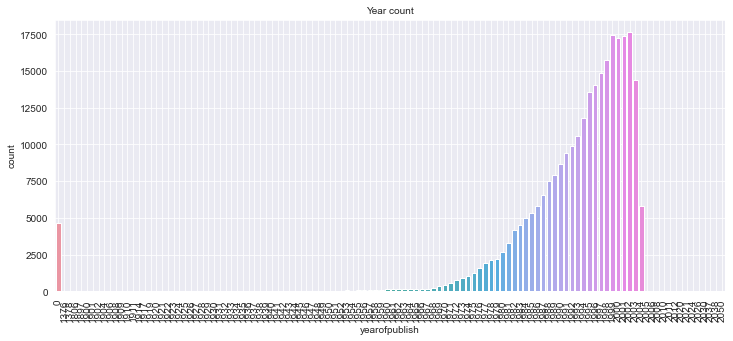

The unique values in our years of book available are:
[   0 1376 1378 1806 1897 1900 1901 1902 1904 1906 1908 1909 1910 1911
 1914 1917 1919 1920 1921 1922 1923 1924 1925 1926 1927 1928 1929 1930
 1931 1932 1933 1934 1935 1936 1937 1938 1939 1940 1941 1942 1943 1944
 1945 1946 1947 1948 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958
 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972
 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986
 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000
 2001 2002 2003 2004 2005 2006 2008 2010 2011 2012 2020 2021 2024 2026
 2030 2037 2038 2050]
We could see that we have more data on books as we proceed towards the end of 20th Century


In [36]:
# Lets check the year books count
#%matplotlib nbagg
%matplotlib inline
sns.set_style('dark')
plt.figure(figsize=(12,5))
sns.countplot(book[(book.yearofpublish!='DK Publishing Inc') & 
                   (book.yearofpublish!='Gallimard')]['yearofpublish'].astype(int))
plt.title("Year count",size=10)
plt.xticks(rotation=90)
plt.grid()
plt.show()
print("The unique values in our years of book available are:")
print(np.sort(book[(book.yearofpublish!='DK Publishing Inc') & 
                   (book.yearofpublish!='Gallimard')]['yearofpublish'].astype(int).unique()))
print("We could see that we have more data on books as we proceed towards the end of 20th Century")

#### As we would be only recommending the users with Book's and not be recommending with respect to publisher or author, we can drop everything other than title and isbn.<br>
#### However we can use the cumulative/average/sum rating for each user against each author or publishers against their books and recommend accordingly.<br>
#### For this we many need to find similarity between Author-Author or Publisher-Publisher.<br>
#### We would not try to do this here, as we are going to build a simple book recommendation system

In [59]:
# Ideally ISBN numbers has to be unique for each Book.
# But that is not what the case seems to be here. 
# Lets investigate further and try to know why is this showing here
print(f"Number of Unique ISBNs in our book dataset: {book.isbn.unique().shape}")
print(f"Number of Unique Titles in our book dataset: {book.title.unique().shape}")

Number of Unique ISBNs in our book dataset: (271360,)
Number of Unique Titles in our book dataset: (242135,)


In [49]:
book.title.value_counts()

Selected Poems                    27
Little Women                      24
Wuthering Heights                 21
Adventures of Huckleberry Finn    20
The Secret Garden                 20
                                  ..
Forgotten Life                     1
The Sleeper : A Novel              1
Queens                             1
Homicidal Intent                   1
Goblins ;: &amp;, Whirlwind        1
Name: title, Length: 242135, dtype: int64

In [63]:
# The Book "Little Women" appears 24 times in our book dataset.
# Lets take this title to validate our ISBN and Title count mismatch
# Little Women:- This book was originally published in two volumes on 1868 and 1869
# In this case the books were republished by different publishers and on different years
# hence the different ISBN number
# however we can surely say that the content would be the same of the book.
# Therefore as we would reccommend the user with only the book's name and not the book by publisher
# We can ignore the different isbn as we would not need it t omake recommendations
book[book.title=='Little Women']

,isbn,title,author,yearofpublish,publisher
3952,185854176X,Little Women,Louisa M. Atcott,1995,Brimax Books Ltd
4330,0861782356,Little Women,Louisa May Alcott,0,Octopus Publising Group Plc
12227,0590203509,Little Women,Louisa May Alcott,1994,Scholastic
20676,0440447682,Little Women,Louisa May Alcott,1990,Yearling Books
32837,1550134140,Little Women,Louisa May Alcott,0,Firefly Books Ltd
52210,0451529308,Little Women,Louisa May Alcott,2004,Signet Classics
52551,0451518144,Little Women,Louisa May Alcott,1983,Signet Book
53358,0590437976,Little Women,Louisa May Alcott,1992,Scholastic
57432,0195813898,Little Women,Alcott,1985,Oxford University Press
72168,0785788727,Little Women,Louisa May Alcott,1999,Sagebrush Bound


In [5]:
book.drop(['author', 'yearofpublish', 'publisher'],axis = 1,inplace=True)
book.head()

,isbn,title
0,0195153448,Classical Mythology
1,0002005018,Clara Callan
2,0060973129,Decision in Normandy
3,0374157065,Flu: The Story of the Great Influenza Pandemic...
4,0393045218,The Mummies of Urumchi


### User DataFrame

In [66]:
user.head()

,userid,location,age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [72]:
user.isna().sum()

userid          0
age        110762
city            0
state           1
country      4577
dtype: int64

In [67]:
per = (user['age'][user.age>=100].value_counts().shape[0]/user.shape[0])*100
print(f"Percentage of users with Age above 90: {per} %")
per = (user['age'][user.age<5].value_counts().shape[0]/user.shape[0])*100
print(f"Percentage of users with Age less than 5: {per} %")
per = ((user['age'].isna().sum())/user.shape[0])*100
print(f'Percentage of NaN Age: {per} %')

Percentage of users with Age above 90: 0.0233093545819019 %
Percentage of users with Age less than 5: 0.0017930272755309151 %
Percentage of NaN Age: 39.71985741847105 %


In [68]:
# The Location field has city, state and country
# Lets split them into different column and start our analysis
user[['city','state','country']] = user['location'].str.split(', ', 2,expand=True)
user.pop('location')
user.head()

,userid,age,city,state,country
0,1,NaN,nyc,new york,usa
1,2,18.0,stockton,california,usa
2,3,NaN,moscow,yukon territory,russia
3,4,17.0,porto,v.n.gaia,portugal
4,5,NaN,farnborough,hants,united kingdom


In [91]:
np.sort(user.age.dropna().unique())

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 113., 114., 115., 116., 118., 119., 123., 124., 127.,
       128., 132., 133., 136., 137., 138., 140., 141., 143., 146., 147.,
       148., 151., 152., 156., 157., 159., 162., 168., 172., 175., 183.,
       186., 189., 199., 200., 201., 204., 207., 20

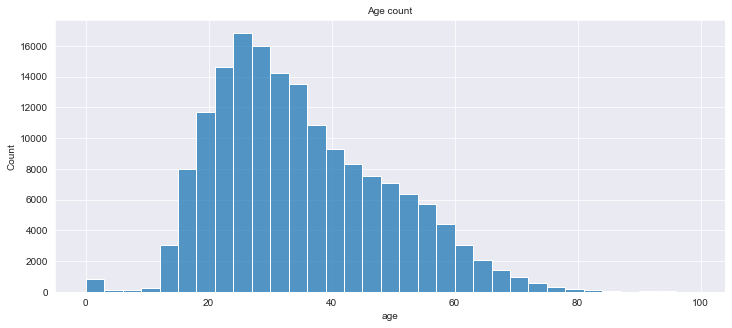

In [96]:
# Lets check our Age Disctibution
# We can see that the ages of the users goes upto 244 years.
# This is impossible for a user to age 244 years and reviewing books
# Also users with below 5 years of age cannot review a book
# As there are almost 40% of the data missing, hence we cannot fill the emply space
# Alos cannot draw any conclusion from the Age feature.
# Would drop the feature all together
sns.set_style('dark')
plt.figure(figsize=(12,5))
sns.histplot(user.age.dropna().astype(int),bins=np.arange(0,101,3),legend=True)
plt.title("Age count",size=10)
#plt.xticks(rotation=90)
plt.grid()
plt.show()

In [97]:
user.country.unique()

array(['usa', 'russia', 'portugal', ..., 'la svizzera', 'hernando',
       'united kingdom.'], dtype=object)

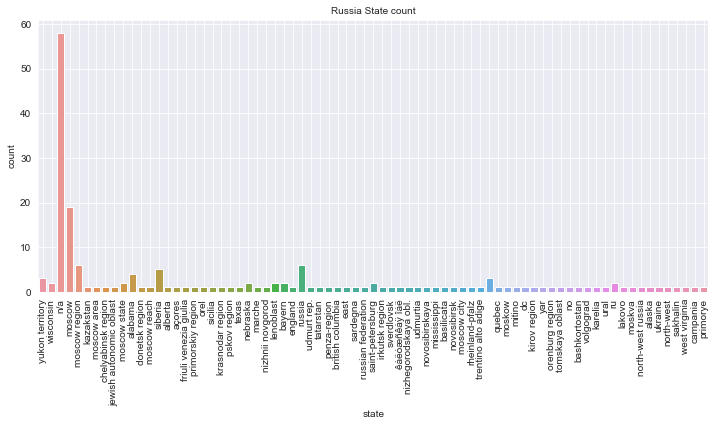

In [101]:
sns.set_style('dark')
plt.figure(figsize=(12,5))
sns.countplot(user[user.country=="russia"]['state'])
plt.title("Russia State count",size=10)
plt.xticks(rotation=90)
plt.grid()
plt.show()

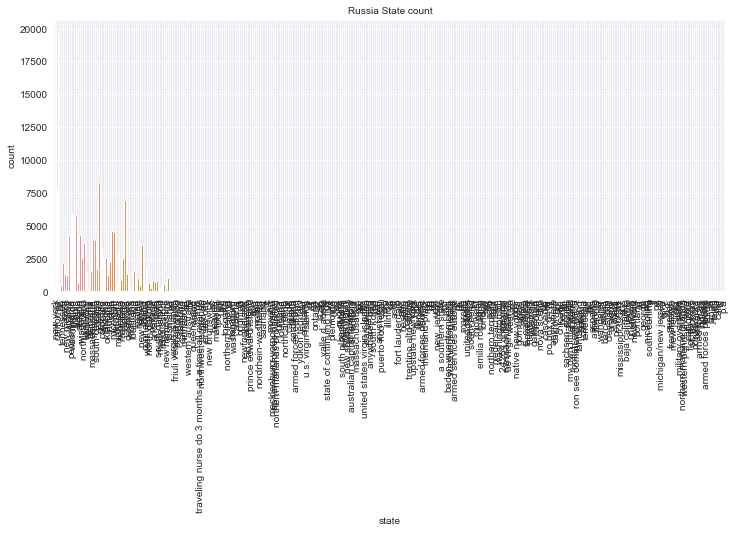

States in USA:



array(['new york', 'california', 'dc', 'tennessee', 'iowa', 'new mexico',
       'virginia', 'pennsylvania', 'washington', 'illinois', 'alaska',
       'oregon', 'wisconsin', 'north carolina', 'kentucky', 'wyoming',
       'alabama', 'massachusetts', 'missouri', 'south carolina', 'texas',
       'georgia', 'colorado', 'arizona', 'oklahoma', 'indiana', 'ohio',
       'michigan', 'vermont', 'minnesota', 'nebraska', 'maryland',
       'florida', 'kansas', 'delaware', 'montana', 'louisiana', 'n/a',
       'maine', 'hawaii', 'new jersey', 'idaho', 'connecticut',
       'west virginia', 'north dakota', 'nevada', 'arkansas', 'utah',
       'south dakota', 'rhode island', 'mississippi', '', 'new hampshire',
       'tasmania', 'ca', 'virgin islands', 'friuli venezia giulia',
       'puerto rico', 'calabria', 'campania', 'minnasota', 'ae',
       'western australia', 'tx', 'queensland', 'wales', 'mo',
       'traveling nurse do 3 months at a time all over us',
       'northwest territories', 'ap

In [104]:
# There is no exact format in our Location Data.
# Hence it would be impossible for us to do any analysis if the format of the data is all over the space.
# Also we will not be recommending the user with the Book, based on the location
# Hence we would not need the dataset
sns.set_style('dark')
plt.figure(figsize=(12,5))
sns.countplot(user[user.country=="usa"]['state'])
plt.title("Russia State count",size=10)
plt.xticks(rotation=90)
plt.grid()
plt.show()
print("States in USA:\n")
user[user.country=="usa"]['state'].unique()

### Rating

In [105]:
rating.head()

,userid,isbn,rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [117]:
rating.isna().sum()

userid    0
isbn      0
rating    0
dtype: int64

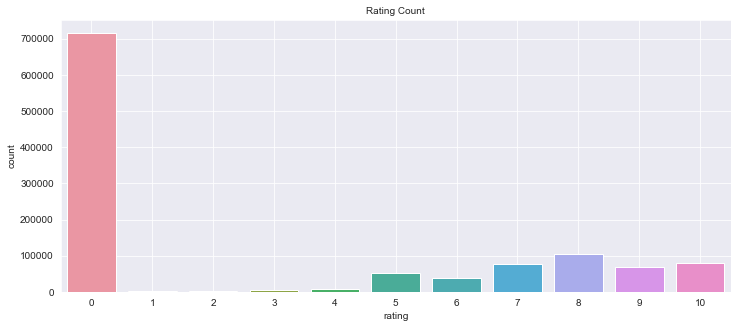

Rating Count: 


0     716109
8     103736
10     78610
7      76457
9      67541
5      50974
6      36924
4       8904
3       5996
2       2759
1       1770
Name: rating, dtype: int64

In [108]:
# The Ratings are given in a range of 1 to 10
# Here we see that the range maximum rating is of 0
sns.set_style('dark')
plt.figure(figsize=(12,5))
sns.countplot(rating['rating'])
plt.title("Rating Count",size=10)
plt.grid()
plt.show()
print("Rating Count: ")
rating.rating.value_counts()

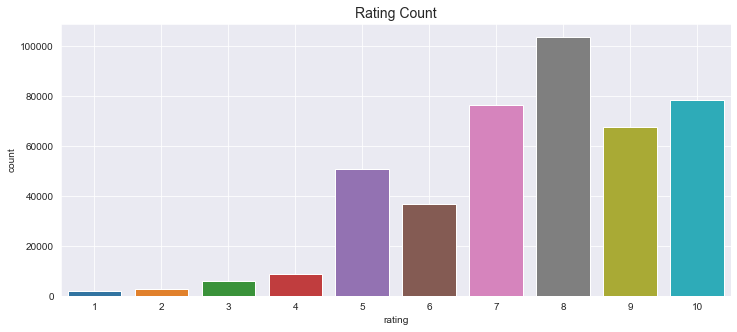

In [115]:
sns.set_style('dark')
plt.figure(figsize=(12,5))
sns.countplot(rating[rating.rating>0]['rating'])
plt.title("Rating Count",size=14)
plt.grid()
plt.show()

In [6]:
# To make recommendataions we need ratings to be between 1-10, hence let modify as per our requirement
rating = rating[rating.rating>0]

## Final DataFrame

In [8]:
# We are performing innerjoin as there are a lot of mismatch ISBN's, both for user and books
data = pd.merge(rating,book, how='inner', on='isbn')
data.reset_index(drop=True,inplace=True)
data.head()

,userid,isbn,rating,title
0,276726,0155061224,5,Rites of Passage
1,276729,052165615X,3,Help!: Level 1
2,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...
3,276744,038550120X,7,A Painted House
4,11676,038550120X,10,A Painted House


In [11]:
data.shape

(383842, 4)

In [9]:
data.isna().sum()

userid    0
isbn      0
rating    0
title     0
dtype: int64

In [16]:
data['title'].unique().shape

(135567,)

In [17]:
data['isbn'].unique().shape

(149836,)

In [18]:
np.sort(data.title.unique())

array([' A Light in the Storm: The Civil War Diary of Amelia Martin, Fenwick Island, Delaware, 1861 (Dear America)',
       ' Ask Lily (Young Women of Faith: Lily Series, Book 5)',
       ' Dark Justice', ..., 'Ã?Â?sterlich leben.',
       'Ã?Â?stlich der Berge.', 'Ã?Â?thique en toc'], dtype=object)

In [19]:
# We do not need 'ISBN', we only need to work with user,title and ratings
data.drop(['isbn'],axis = 1, inplace=True)
data.head()

,userid,rating,title
0,276726,5,Rites of Passage
1,276729,3,Help!: Level 1
2,276729,6,The Amsterdam Connection : Level 4 (Cambridge ...
3,276744,7,A Painted House
4,11676,10,A Painted House


In [20]:
data.reset_index(drop=True,inplace=True)

In [31]:
data[data.userid==np.sort(data.userid.unique())[500]]

,userid,rating,title
60510,2097,9,Veronika Decides to Die


In [32]:
data[data.userid==np.sort(data.userid.unique())[600]]

,userid,rating,title
65187,2421,8,Bailey's Cafe


In [33]:
data[data.title==np.sort(data.title.unique())[500]]

,userid,rating,title
278834,86947,10,200 Great Painting Ideas for Artists


In [35]:
data[data.title==np.sort(data.title.unique())[600]]

,userid,rating,title
43425,638,10,"28 Barbary Lane : A \Tales of the City\"" Omnibus"""
43426,24186,10,"28 Barbary Lane : A \Tales of the City\"" Omnibus"""
43427,177458,9,"28 Barbary Lane : A \Tales of the City\"" Omnibus"""


To make any conclusive recommendations, we need books which have a rating of more than 50<br>
Also users who have rated 50 or more books<br>
This is needed to make sure that our model works well and also get a definative understanding of the product that we are dealing with.<br>
If our model works well, it could also predict for unseen data and make recommendations for users and books with less ratings<br>

In [44]:
# First lets create a column which shows the number of ratings against each book
data['num_rat']=0
for i in tqdm(list(data.title.unique())):
    masx = (data.title==i)
    count = data[masx]['title'].count()
    data.loc[masx,'num_rat']=data.loc[masx,'num_rat'].replace(to_replace=0, value=count)

100%|████████████████████████████████████████████████████████████████████████| 135567/135567 [1:24:41<00:00, 26.68it/s]


In [45]:
data['user_rat']=0
for i in tqdm(list(data.userid.unique())):
    masx = (data.userid==i)
    count = data[masx]['userid'].count()
    data.loc[masx,'user_rat']=data.loc[masx,'user_rat'].replace(to_replace=0, value=count)

100%|███████████████████████████████████████████████████████████████████████████| 68091/68091 [06:11<00:00, 183.12it/s]


In [1]:
data.to_csv("data_redy.csv")

## Transforming data to user vs rating matrix

In [4]:
data = pd.read_csv("data_redy.csv")
data.shape

(383842, 5)

In [3]:
data.head()

,userid,rating,title,num_rat,user_rat
0,276726,5,Rites of Passage,5,1
1,276729,3,Help!: Level 1,1,2
2,276729,6,The Amsterdam Connection : Level 4 (Cambridge ...,1,2
3,276744,7,A Painted House,366,1
4,11676,10,A Painted House,366,6943


In [4]:
np.sort(data['num_rat'].unique())

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 110, 111, 112, 113, 114, 115, 116, 118, 120,
       121, 122, 123, 124, 125, 126, 127, 129, 130, 131, 133, 134, 135,
       136, 137, 138, 139, 142, 143, 144, 145, 146, 147, 149, 150, 151,
       153, 154, 156, 158, 159, 160, 161, 163, 165, 166, 171, 174, 176,
       177, 181, 182, 183, 185, 186, 189, 192, 194, 195, 198, 204, 205,
       206, 207, 208, 211, 212, 213, 214, 217, 218, 224, 228, 23

In [5]:
np.sort(data['user_rat'].unique())

array([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
         12,   13,   14,   15,   16,   17,   18,   19,   20,   21,   22,
         23,   24,   25,   26,   27,   28,   29,   30,   31,   32,   33,
         34,   35,   36,   37,   38,   39,   40,   41,   42,   43,   44,
         45,   46,   47,   48,   49,   50,   51,   52,   53,   54,   55,
         56,   57,   58,   59,   60,   61,   62,   63,   64,   65,   66,
         67,   68,   69,   70,   71,   72,   73,   74,   75,   76,   77,
         78,   79,   80,   81,   82,   83,   84,   85,   86,   87,   88,
         89,   90,   91,   92,   93,   94,   95,   96,   97,   98,   99,
        100,  101,  102,  103,  104,  105,  106,  107,  108,  109,  110,
        111,  112,  113,  114,  115,  116,  117,  118,  119,  120,  121,
        122,  123,  124,  125,  126,  127,  128,  129,  130,  131,  132,
        133,  134,  135,  136,  137,  138,  139,  140,  141,  142,  143,
        144,  145,  146,  148,  149,  150,  151,  1

<IPython.core.display.Javascript object>


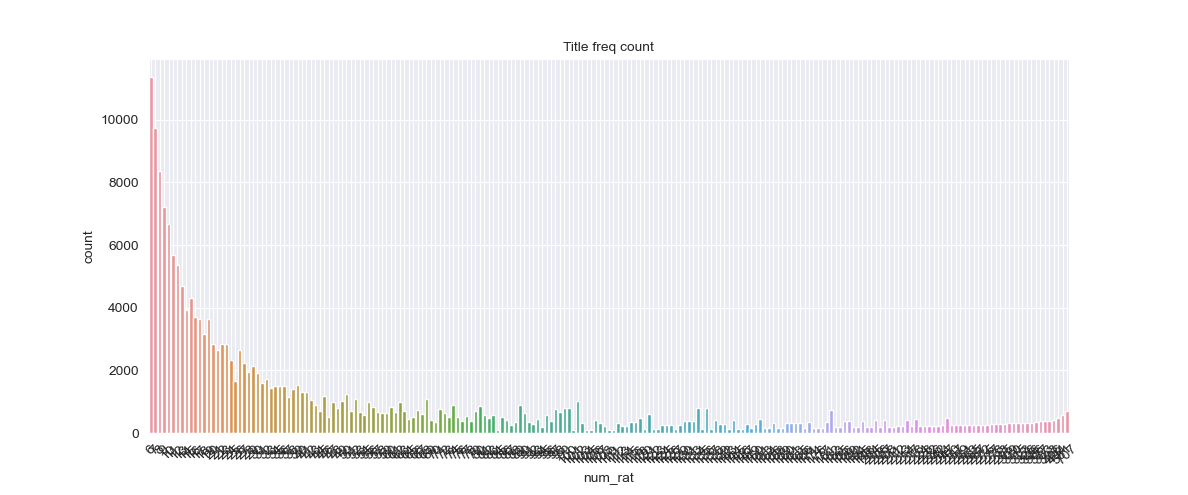

In [13]:
#%matplotlib nbagg
#%matplotlib inline
%matplotlib qt
sns.set_style('dark')
plt.figure(figsize=(12,5))
sns.countplot(data[(data.num_rat>5)]['num_rat'])
plt.title("Title freq count",size=10)
plt.xticks(rotation=45)
plt.grid()
plt.show()

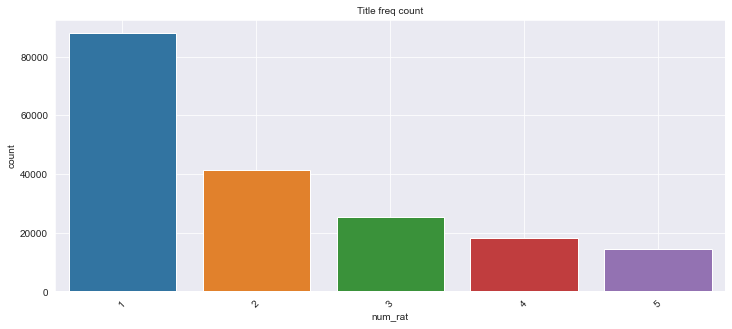

In [15]:
#%matplotlib nbagg
%matplotlib inline
#%matplotlib qt
sns.set_style('dark')
plt.figure(figsize=(12,5))
sns.countplot(data[(data.num_rat<6)]['num_rat'])
plt.title("Title freq count",size=10)
plt.xticks(rotation=45)
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


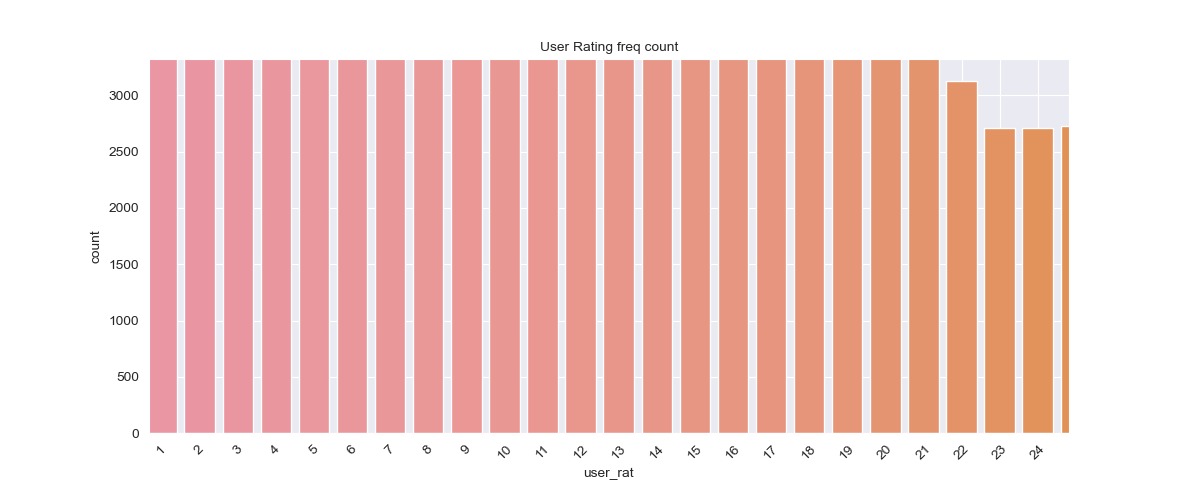

In [16]:
#%matplotlib nbagg
#%matplotlib inline
%matplotlib qt
sns.set_style('dark')
plt.figure(figsize=(12,5))
sns.countplot(data['user_rat'])
plt.title("User Rating freq count",size=10)
plt.xticks(rotation=45)
plt.grid()
plt.show()

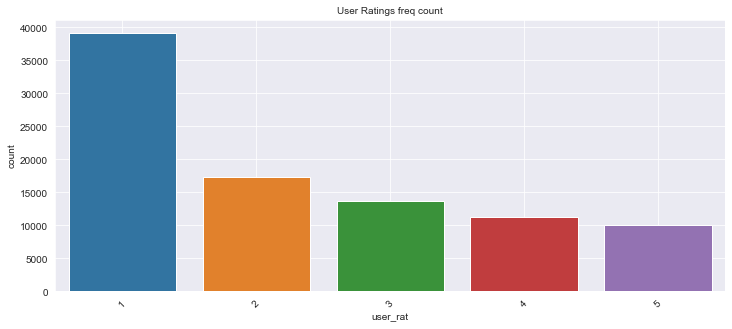

In [17]:
#%matplotlib nbagg
%matplotlib inline
#%matplotlib qt
sns.set_style('dark')
plt.figure(figsize=(12,5))
sns.countplot(data[(data.user_rat<6)]['user_rat'])
plt.title("User Ratings freq count",size=10)
plt.xticks(rotation=45)
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


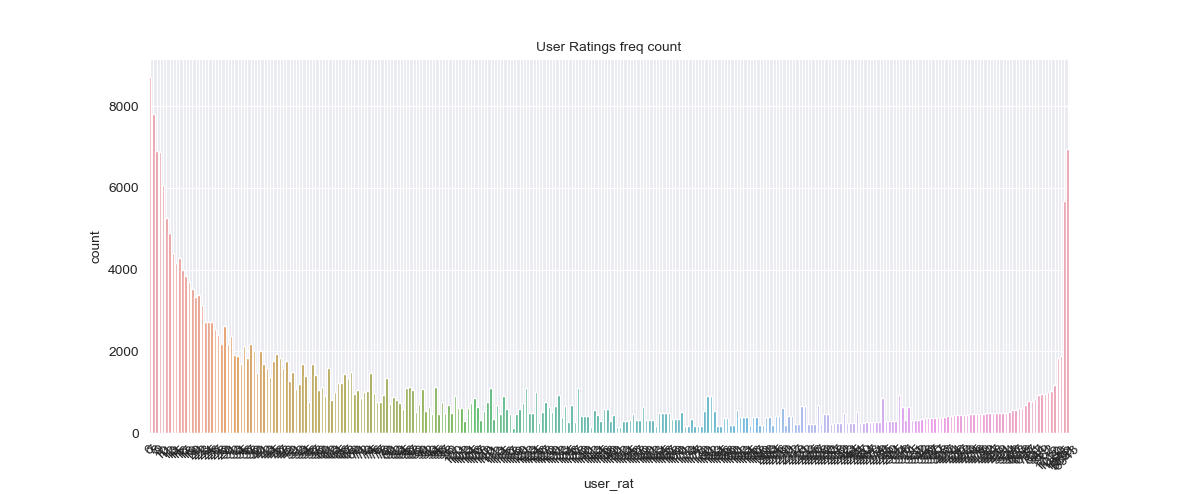

In [20]:
#%matplotlib nbagg
#%matplotlib inline
%matplotlib qt
sns.set_style('dark')
plt.figure(figsize=(12,5))
sns.countplot(data[(data.user_rat>5)]['user_rat'])
plt.title("User Ratings freq count",size=10)
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [22]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
userid,383842.0,136031.461260,80482.299401,8.0,67591.0,133789.0,206219.0,278854.0
rating,383842.0,7.626701,1.841339,1.0,7.0,8.0,9.0,10.0
num_rat,383842.0,32.308236,70.442000,1.0,2.0,6.0,27.0,707.0
user_rat,383842.0,314.729347,1150.589653,1.0,6.0,29.0,111.0,6943.0


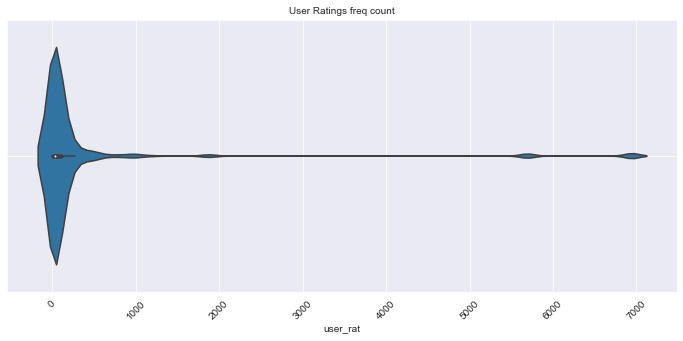

In [25]:
#%matplotlib nbagg
%matplotlib inline
#%matplotlib qt
sns.set_style('dark')
plt.figure(figsize=(12,5))
sns.violinplot(data['user_rat'])
plt.title("User Ratings freq count",size=10)
plt.xticks(rotation=45)
plt.grid()
plt.show()

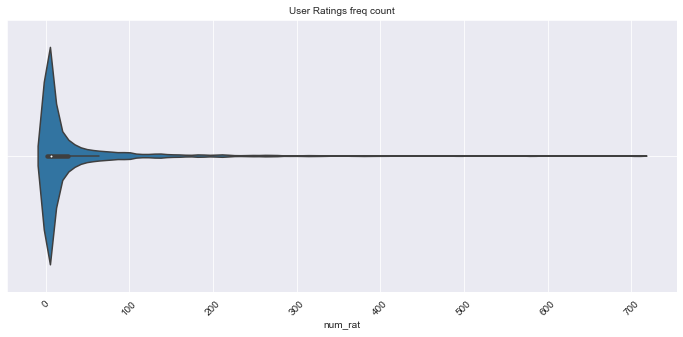

In [26]:
#%matplotlib nbagg
%matplotlib inline
#%matplotlib qt
sns.set_style('dark')
plt.figure(figsize=(12,5))
sns.violinplot(data['num_rat'])
plt.title("User Ratings freq count",size=10)
plt.xticks(rotation=45)
plt.grid()
plt.show()

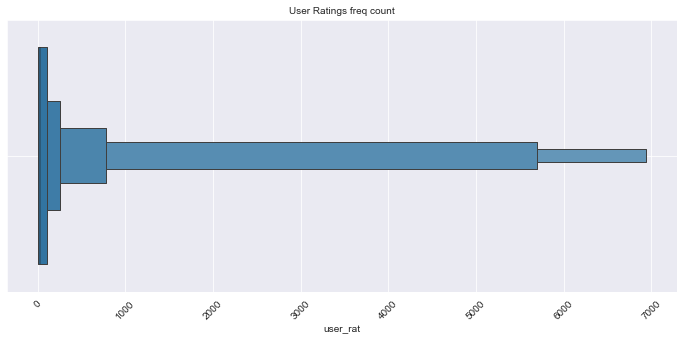

In [30]:
#%matplotlib nbagg
%matplotlib inline
#%matplotlib qt
sns.set_style('dark')
plt.figure(figsize=(12,5))
sns.boxenplot(data['user_rat'])
plt.title("User Ratings freq count",size=10)
plt.xticks(rotation=45)
plt.grid()
plt.show()

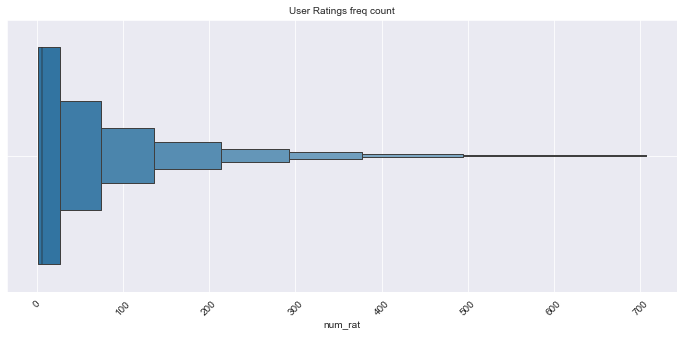

In [29]:
#%matplotlib nbagg
%matplotlib inline
#%matplotlib qt
sns.set_style('dark')
plt.figure(figsize=(12,5))
sns.boxenplot(data['num_rat'])
plt.title("User Ratings freq count",size=10)
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [45]:
# We could observe here very well, that book rated for most of the user is near to zero.
# Hence it would be difficult for make a recommendation depending upon less data
# However there are some popular books which has been rated by most of the users.
print(f'Taking the threshold as 5 for both user and book rated, we would have: {data[(data.num_rat>5)&(data.user_rat>5)].shape[0]/data.shape[0]*100} % of data left')
print(f'Taking the threshold as 100 for both user and book rated, we would have: {data[(data.num_rat>100)&(data.user_rat>100)].shape[0]/data.shape[0]*100} % of data left')
print(f'Taking the threshold as 10 for both user and book rated, we would have: {data[(data.num_rat>10)&(data.user_rat>10)].shape[0]/data.shape[0]*100} % of data left')

Taking the threshold as 5 for both user and book rated, we would have: 37.342969242552925 % of data left
Taking the threshold as 100 for both user and book rated, we would have: 1.2869878752194914 % of data left
Taking the threshold as 10 for both user and book rated, we would have: 24.387117616102458 % of data left


In [5]:
# We set the threshold at '5', and remove every user and book which has a number of ratings lower than '5'
data = data[(data.num_rat>5)&(data.user_rat>5)]
data.head()

,userid,rating,title,num_rat,user_rat
4,11676,10,A Painted House,366,6943
5,16877,9,A Painted House,366,10
9,21356,7,A Painted House,366,24
10,22625,10,A Painted House,366,97
12,29168,7,A Painted House,366,6


In [6]:
data['movie_encode']=0
count = 0
for i in tqdm(list(data.title.unique())):
    count = count+1
    masx = (data.title==i)
    data.loc[masx,'movie_encode']=data.loc[masx,'movie_encode'].replace(to_replace=0, value=count)

100%|████████████████████████████████████████████████████████████████████████████| 10835/10835 [02:28<00:00, 73.16it/s]


In [7]:
data.head()

,userid,rating,title,num_rat,user_rat,movie_encode
4,11676,10,A Painted House,366,6943,1
5,16877,9,A Painted House,366,10,1
9,21356,7,A Painted House,366,24,1
10,22625,10,A Painted House,366,97,1
12,29168,7,A Painted House,366,6,1


In [72]:
data['title'].unique().shape

(10835,)

In [73]:
data['movie_encode'].unique().shape

(10835,)

In [80]:
data['userid'].unique().shape

(10485,)

In [79]:
train_sparse_matrix.shape

(278855, 10836)

# Collaborative Filtering - Cosine Similarity item-item

In [23]:
data.head()

,userid,rating,title,num_rat,user_rat,movie_encode
4,11676,10,A Painted House,366,6943,1
5,16877,9,A Painted House,366,10,1
9,21356,7,A Painted House,366,24,1
10,22625,10,A Painted House,366,97,1
12,29168,7,A Painted House,366,6,1


In [8]:
data_trn = data.drop_duplicates(['userid', 'title'])
data_trn = data_trn.pivot(index = 'title', columns = 'userid', values = 'rating').fillna(0)

In [62]:
data_trn.head()

userid,8,99,114,242,243,244,254,300,383,388,...,278529,278535,278552,278554,278582,278633,278694,278843,278851,278854
title,,,,,,,,,,,,,,,,,,,,,
"Earth Prayers From around the World: 365 Prayers, Poems, and Invocations for Honoring the Earth",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
!Yo!,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Salem's Lot,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01-01-00: The Novel of the Millennium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10 Lb. Penalty,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
model = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(data_trn)

NearestNeighbors(algorithm='brute', metric='cosine')


In [46]:
distances, indices = model.kneighbors(data_trn,n_neighbors=5)

In [57]:
data_trn[:10].index[9]

'1001 Ways to Be Romantic'

In [58]:
data_trn.index[indices[9]]

Index(['1001 Ways to Be Romantic', 'The King's Buccaneer', 'Separate Peace',
       'Blue Moon Rising (Hawk &amp; Fisher)', 'Danny and the Dinosaur'],
      dtype='object', name='title')

Here we get the indices for all the similar items. The most similar item would be the item itself.<br>
We can now easily find 5 similar books with respect to our training data<br>
We have used simple cosine similarity to find get the similarity